In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import copy as cp

import time

In [3]:
def softmax(x,beta):
    #return softmax function output
    #when x is very large or very small, np.exp(x) become wrong due to overflow.
    #so I avoid the problem naively.
    x=x*beta
    if np.max(x)>500:
        temp=np.zeros_like(x)
        temp[np.argmax(x)]=1
        return temp
    if np.max(x)<-500:
        temp=np.zeros_like(x) + 0.25
        return temp
    else:
        temp=np.exp(x)
        return temp/np.sum(temp)

def move(place,action_choosed):
    #get next place from current place and choosed action
    place_next=cp.deepcopy(place)
    if action_choosed==0:
        place_next[0]+=1
    elif action_choosed==1:
        place_next[1]+=1
    elif action_choosed==2:
        place_next[0]-=1
    elif action_choosed==3:
        place_next[1]-=1
    return place_next

def plot_trace(place_hist):
    #plot trace by scatter
    place_hist=np.array(place_hist)
    plt.scatter(place_hist[:,1],place_hist[:,0])
    plt.scatter(place_hist[0,1],place_hist[0,0],color='k',linewidths=3,label='start')
    plt.scatter(place_hist[-1,1],place_hist[-1,0],color='r',linewidths=3,label='reward')
    plt.xlim([0,n])
    plt.ylim([0,n])


def plot_trace2(place_hist):
    #plot trace by line, though this is compulationaly expensive
    n_step=len(place_hist)
    for i in range(n_step-1):
        x=[place_hist[i][1],place_hist[i+1][1]]
        y=[place_hist[i][0],place_hist[i+1][0]]
        c=1.0*i/n_step
        plt.plot(x,y,color=[c,0,0])

    plt.xlim([0,n])
    plt.ylim([0,n])
    plt.scatter(place_hist[0][1],place_hist[0][0],color='k',linewidths=3,label='start')
    plt.scatter(place_hist[-1][1],place_hist[-1][0],color='r',linewidths=3,label='reward')



In [8]:
#setting and initialization

n=20#field size

r_place=[3,5]#reward place
M_a=np.zeros([n,n,4])#weight used for calculating action
M_v=np.zeros([n,n])#weight used for calculating value

take_time_rec=[]#list for recording time taken in each trial 
min_time_rec=[]#list for recording minimal (optimal) time taken in each trial
place_hist_rec=[]#list for recording place history 

plot_trials=[0,500,10000,15500]#trials used for plot
M_v_rec=[]#list for recording M_v in trials used for plot
M_a_rec=[]#list for recording M_a in trials used for plot

beta_change_trial=15000#when beta is changed

In [25]:


np.random.seed(100)

#hyperparameters
eps_v=0.1
eps_a=0.1
beta=1
beta_later=10
gamma=0.9

time_taken=time.time()

#trial loop
for trial in range(16000):
    if np.mod(trial,1000)==0:
        print '{} trials done'.format(trial)
    
    if trial == beta_change_trial:
        beta=beta_later
        
    #initialize for this trial
    trial_end=0
    t=0
    
    #initial place
    if trial in plot_trials:
        place_start=[14,9]
        M_v_rec.append(M_v.copy())
        M_a_rec.append(M_a.copy())
    else:
        while True:
            place_start=[np.random.randint(n),np.random.randint(n)]
            if not place_start==r_place: #I avoid that start place and reward place become same.
                break
    place=cp.deepcopy(place_start) 
    min_time_rec.append(np.sum(np.abs(np.array(place_start)-np.array(r_place))))
    
    place_hist=[]
    
    #step loop in one trial
    while trial_end==0:  
        place_hist.append(place)
        
        #action
        temp=M_a[place[0],place[1]]
        p_a=softmax(temp,beta)
        while True:
            action_choosed=np.random.choice(range(4),p=p_a)
            place_next=move(place,action_choosed)
            if (not n in place_next) and (not -1 in place_next):
                break
        #value
        v_pre=M_v[place[0],place[1]]
        v_post=M_v[place_next[0],place_next[1]]

        #reward 
        r=0
        if place==r_place:
            r=1
            trial_end=1
        
        #update critic
        delta= r + v_post*gamma - v_pre
        M_v[place[0],place[1]]+=delta*eps_v
        
        #update actor
        delta_a_a=np.zeros(4)
        delta_a_a[action_choosed]=1
        M_a[place[0],place[1],:]+=(delta_a_a-p_a) * delta * eps_a
        
        #prepare for next time step
        place=cp.deepcopy(place_next)
        if trial_end==1:
            take_time_rec.append(t)
        t+=1
        
    place_hist_rec.append(place_hist)
print 'taken time : {}'.format(time.time()-time_taken)

0 trials done
1000 trials done
2000 trials done
3000 trials done
4000 trials done
5000 trials done
6000 trials done
7000 trials done
8000 trials done
9000 trials done
10000 trials done
11000 trials done
12000 trials done
13000 trials done
14000 trials done
15000 trials done
18.2381949425


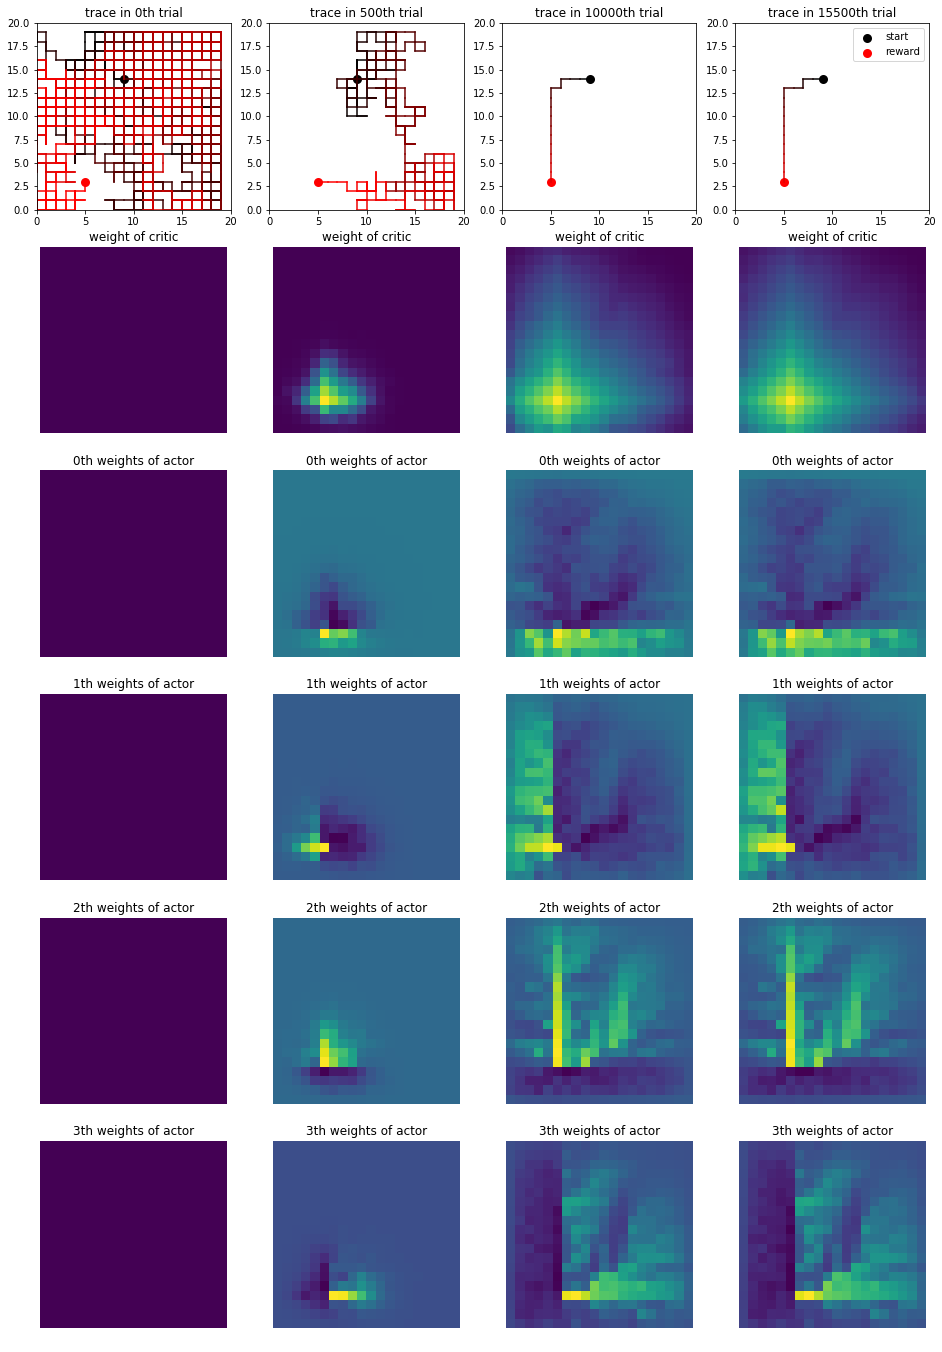

In [26]:
plt.figure(figsize=[4*len(plot_trials),4*6])
for k,plot_trial in enumerate(plot_trials):
    plt.subplot(6,len(plot_trials),k+1)
    plot_trace2(place_hist_rec[plot_trial])
    #plot_trace(place_hist_rec[plot_trial])
    plt.title('trace in {}th trial'.format(plot_trial))
    if k==len(plot_trials)-1:
        plt.legend()
    
    plt.subplot(6,len(plot_trials),k+5)
    plt.imshow(M_v_rec[k][::-1])
    plt.title('weight of critic')
    plt.axis('off')
    
    for i in range(4):
        plt.subplot(6,len(plot_trials),k+9+4*i)
        plt.imshow(M_a_rec[k][::-1,:,i])
        plt.title('{}th weights of actor'.format(i))
        plt.axis('off')
    


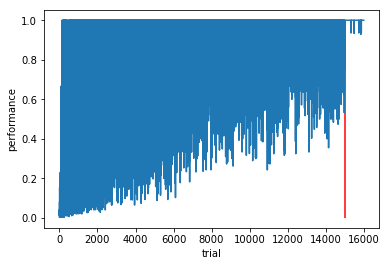

In [10]:
perf=1.0*np.array(min_time_rec)/np.array(take_time_rec)
plt.plot(perf)
plt.vlines(beta_change_trial,0,1,'r')
plt.xlabel('trial')
plt.ylabel('performance')
